# 04 - Train Detectron2 - Putting All Steps Together
<img src="https://dl.fbaipublicfiles.com/detectron2/Detectron2-Logo-Horz.png" width="500">
In this series, we have walked through how to read COCO and Open Images datasets for object detection, how to format Open Images dataset for Detectron2, and how to train Detectron2 on a small dataset. In this notebook, we put all previous steps together to train Detectron2 long enough on a large datasets of musical instruments.

In [1]:
%cd open-images-v6/

/mnt/data/object_detection/open-images-v6


In [2]:
import os, cv2, random, json
from tqdm import tqdm
import subprocess
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (20.0, 10.0)

# detectron2
import detectron2
from detectron2 import model_zoo
from detectron2.config import get_cfg
from detectron2.engine import DefaultPredictor

from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog
from detectron2.structures import BoxMode

## 1. Download Open Images V6

In previous notebook we have used Open Images V5. In 2020 Google have released Open Images V6 with more training images, which is what we are going to use in this notebook.

Download annotation files ([more details](https://storage.googleapis.com/openimages/web/download.html)):

In [ ]:
# train-annotations-bbox (2.10G)
!wget https://storage.googleapis.com/openimages/v6/oidv6-train-annotations-bbox.csv

# validation-annotations-bbox (23.94M)
!wget https://storage.googleapis.com/openimages/v5/validation-annotations-bbox.csv
    
# test-annotations-bbox (73.89M)
!wget https://storage.googleapis.com/openimages/v5/test-annotations-bbox.csv

# class-descriptions (448.58.73K)
!wget https://storage.googleapis.com/openimages/v6/oidv6-class-descriptions.csv

We will use [`downloadOI.py`](https://raw.githubusercontent.com/spmallick/learnopencv/master/downloadOpenImages/downloadOI.py) from [learnopencv's tutorial](https://www.learnopencv.com/fast-image-downloader-for-open-images-v4/) to download specific classes. This script was written for Open Images v4. I have modified it a little bit to use for v6.

In [ ]:
!wget https://raw.githubusercontent.com/chriskhanhtran/object-detection-detectron2/master/open-images-v6/downloadOI.py

We need to rename some files to be able to run `downloadOI.py`:

In [ ]:
!mv oidv6-class-descriptions.csv class-descriptions-boxable.csv
!mv oidv6-train-annotations-bbox.csv train-annotations-bbox.csv

All classes in Open Images: [Flare Dendrogram](https://storage.googleapis.com/openimages/2018_04/bbox_labels_600_hierarchy_visualizer/circle.html). Below are classes under "Musical Instruments".

In [3]:
target_classes = [
    'Accordion',
    'Banjo',
    'Cello',
    'Chime',
    'Drum',
    'Flute',
    'French horn',
    'Guitar',
    'Harmonica',
    'Harp',
    'Harpsichord',
    'Maracas',
    'Musical keyboard',
    'Oboe',
    'Organ (Musical Instrument)',
    'Piano',
    'Saxophone',
    'Trombone',
    'Trumpet',
    'Violin'
 ]

len(target_classes)

20

Download target classes:

In [46]:
# Download target classes
target_classes_str = ",".join(target_classes).replace(" ", "_")
!python3 downloadOI.py --classes 'Accordion,Banjo,Cello,Chime,Drum,Flute,French_horn,Guitar,Harmonica,Harp,Harpsichord,Maracas,Musical_keyboard,Oboe,Organ_(Musical_Instrument),Piano,Saxophone,Trombone,Trumpet,Violin' --mode train
!python3 downloadOI.py --classes 'Accordion,Banjo,Cello,Chime,Drum,Flute,French_horn,Guitar,Harmonica,Harp,Harpsichord,Maracas,Musical_keyboard,Oboe,Organ_(Musical_Instrument),Piano,Saxophone,Trombone,Trumpet,Violin' --mode validation

Class 0 : Accordion
Class 1 : Banjo
Class 2 : Cello
Class 3 : Chime
Class 4 : Drum
Class 5 : Flute
Class 6 : French_horn
Class 7 : Guitar
Class 8 : Harmonica
Class 9 : Harp
Class 10 : Harpsichord
Class 11 : Maracas
Class 12 : Musical_keyboard
Class 13 : Oboe
Class 14 : Organ_(Musical_Instrument)
Class 15 : Piano
Class 16 : Saxophone
Class 17 : Trombone
Class 18 : Trumpet
Class 19 : Violin
Annotation Count : 66310
Number of images to be downloaded : 29184
100%|█████████████████████████████████████| 29184/29184 [59:10<00:00,  8.22it/s]
Class 0 : Accordion
Class 1 : Banjo
Class 2 : Cello
Class 3 : Chime
Class 4 : Drum
Class 5 : Flute
Class 6 : French_horn
Class 7 : Guitar
Class 8 : Harmonica
Class 9 : Harp
Class 10 : Harpsichord
Class 11 : Maracas
Class 12 : Musical_keyboard
Class 13 : Oboe
Class 14 : Organ_(Musical_Instrument)
Class 15 : Piano
Class 16 : Saxophone
Class 17 : Trombone
Class 18 : Trumpet
Class 19 : Violin
Annotation Count : 798
Number of images to be downloaded : 441
100%|

The downloaded images are saved in `train` and `validation` separately. Because we already have annotation files with train/val split information. We can move all images into one folder for easier processing.

```python
!mkdir -p images
!mv train/* images
!mv validation/* images
```

## 2. Format Annotations

### Create Subset Annotation Dataframes

We create a subset dataframe of each annotation file, which will then be used to transform annotation formats. Creating these subset dataframes helps make processing faster.

After examining the size of each class, I choose only ones with more than 900 annotations.

In [4]:
# Choose classes with > 900 annotations
target_classes = [
    'Accordion',
    'Cello',
    'Drum',
    'French horn',
    'Guitar',
    'Musical keyboard',
    'Piano',
    'Saxophone',
    'Trombone',
    'Trumpet',
    'Violin'
]

# Sort and create ID for each class
target_classes = sorted(target_classes)
class2id = {class_: id_ for id_, class_ in enumerate(target_classes)}
print(class2id)

{'Accordion': 0, 'Cello': 1, 'Drum': 2, 'French horn': 3, 'Guitar': 4, 'Musical keyboard': 5, 'Piano': 6, 'Saxophone': 7, 'Trombone': 8, 'Trumpet': 9, 'Violin': 10}


In the annotation files, classes are saved in encoded strings. We can use `class-descriptions-boxable.csv` to find real class names.

In [5]:
# Get class names
classes = pd.read_csv("class-descriptions-boxable.csv", header=None, names=['LabelName', 'Class'])
subset_classes =classes[classes['Class'].isin(target_classes)]
subset_classes

,LabelName,Class
2547,/m/01xqw,Cello
3663,/m/026t6,Drum
6730,/m/0319l,French horn
6878,/m/0342h,Guitar
11086,/m/057cc,Musical keyboard
11878,/m/05r5c,Piano
12958,/m/06ncr,Saxophone
13699,/m/07c6l,Trombone
13779,/m/07gql,Trumpet
14177,/m/07y_7,Violin


Now we add class names and class ids to annotation dataframes, and create subset train/val annotation files for our target classes.

```python
# Prepare annotation files
for folder in ['train', 'validation']:
    # Load annotation files
    annot_df = pd.read_csv(f"{folder}-annotations-bbox.csv")
    # Inner join with subset_classes
    annot_df = annot_df.merge(subset_classes, on='LabelName')
    # Create `ClassID`
    annot_df['ClassID'] = annot_df['Class'].apply(lambda x: class2id[x])
    # Save subset files
    annot_df.to_csv(f"{folder}-annotations-bbox-target.csv", index=False)
    del annot_df
```

### Data Size

In [6]:
train_df = pd.read_csv("train-annotations-bbox-target.csv")
val_df = pd.read_csv("validation-annotations-bbox-target.csv")

Number of boxes for each class:

In [7]:
data_size = pd.concat([train_df['Class'].value_counts(), val_df['Class'].value_counts()], axis=1)
data_size.columns = ["Train", "Val"]
data_size

,Train,Val
Guitar,25896,119
Drum,24818,121
Violin,2828,36
Cello,2004,38
Musical keyboard,1771,53
Trumpet,1546,65
Piano,1374,100
French horn,1239,64
Saxophone,1208,40
Accordion,955,24


There are 28328 train images, and 399 validation images.

In [8]:
train_df['ImageID'].nunique(), val_df['ImageID'].nunique()

(28328, 399)

## 3. Train Detectron2

The training process is similar to what we have done in notebook 03. I have put together all steps in [`main.py`](https://github.com/chriskhanhtran/object-detection-detectron2/blob/master/open-images-v6/main.py). For all default training hyperparameters, please refer to [this script](https://github.com/facebookresearch/detectron2/blob/master/detectron2/config/defaults.py). In `main.py`, we can specify several important arguments:
- `model`
- `max_iter`
- `lr`
- `lr_decay_step`
- `gamma`: multiplicative factor for each lr decay step
- `warmup_iters`
- `ims_per_batch`

For the purpose of presentation, we create a small dataset for training:

In [9]:
train_imgs = train_df['ImageID'].unique().tolist()
sample_imgs = np.random.choice(train_imgs, int(len(train_imgs) * 0.1))
small_train_df = train_df[train_df['ImageID'].isin(sample_imgs)]
small_train_df.to_csv("small-train-annotations-bbox-target.csv", index=False)

We run the following command to start training:

In [ ]:
cmd = """python main.py \
    --train \
    --train_annot_fp "./small-train-annotations-bbox-target.csv" \
    --eval \
    --val_annot_fp "./validation-annotations-bbox-target.csv" \
    --model "faster_rcnn_X_101_32x8d_FPN_3x" \
    --max_iter 300 \
    --lr 5e-4 \
    --gamma 0.5 \
    --lr_decay_steps 250 300"""

!{cmd}

This [TensorBoard](https://tensorboard.dev/experiment/F3gNNB3TQDa7Z3QaRQopnQ/#scalars) shows the list of experiments I have run, including:

- `faster_rcnn_R_50_FPN_3x__iter-10000__lr-0.005__warmup-1000`
- `faster_rcnn_R_50_FPN_3x__iter-100000__lr-0.001__warmup-1000`
- `faster_rcnn_X_101_32x8d_FPN_3x__iter-20000__lr-0.0005__warmup-1000`
- `retinanet_R_50_FPN_3x__iter-20000__lr-0.0005__warmup-1000`

These experiments were run on a subset of 7 classes. From these experiments, I found learning rate of 5e-3 is too high, and 5e-4 is a good learning rate.

![](./open-images-v6/tensorboard.jpg)

After figuring out the best hyperparameters, I started the final training process for 100,000 steps with 5e-4 learning rate:
- `retinanet_R_101_FPN_3x__iter-100000__lr-0.0005__warmup-1000`: full training of the best model and hyperparameters 

Final model's results:

In [11]:
!tail -n15 retinanet_R_101_FPN_3x__iter-100000__lr-0.0005__warmup-1000/terminal_output.log

[07/14 21:40:10] d2.evaluation.coco_evaluation INFO: Evaluation results for bbox: 
|   AP   |  AP50  |  AP75  |  APs   |  APm   |  APl   |
|:------:|:------:|:------:|:------:|:------:|:------:|
| 45.224 | 65.979 | 51.251 | 20.000 | 32.392 | 45.509 |
[07/14 21:40:10] d2.evaluation.coco_evaluation INFO: Per-category bbox AP: 
| category    | AP     | category   | AP     | category         | AP     |
|:------------|:-------|:-----------|:-------|:-----------------|:-------|
| Accordion   | 75.519 | Cello      | 49.599 | Drum             | 21.705 |
| French horn | 22.323 | Guitar     | 67.951 | Musical keyboard | 28.918 |
| Piano       | 58.557 | Saxophone  | 52.651 | Trombone         | 31.077 |
| Trumpet     | 36.089 | Violin     | 53.073 |                  |        |
[07/14 21:40:10] d2.engine.defaults INFO: Evaluation results for music_val in csv format:
[07/14 21:40:10] d2.evaluation.testing INFO: copypaste: Task: bbox
[07/14 21:40:10] d2.evaluation.testing INFO: copypaste: AP,AP50,AP

## 4. Inference

Now we can use our trained model to detect musical instruments in any image. Let's define some util functions.

In [12]:
target_classes = ['Accordion', 'Cello', 'Drum', 'French horn', 'Guitar',
                  'Musical keyboard', 'Piano', 'Saxophone', 'Trombone',
                  'Trumpet', 'Violin']

def cv2_imshow(im):
    im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
    plt.figure(), plt.imshow(im), plt.axis('off');
    
def detect(pil_im, predictor):
    outputs = predictor(im)
    v = Visualizer(im[:, :, ::-1], music_metadata, scale=0.5)
    out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    cv2_imshow(out.get_image()[:, :, ::-1])

Load trained model from checkpoint and set up predictor.

In [13]:
# Load model
model_dir = "retinanet_R_101_FPN_3x__iter-100000__lr-0.0005__warmup-1000"
cfg = get_cfg()
cfg.merge_from_file(model_dir + '/config.yaml')
cfg.MODEL.WEIGHTS = model_dir + '/model_final.pth'
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.25
cfg.MODEL.RETINANET.SCORE_THRESH_TEST = 0.25
predictor = DefaultPredictor(cfg)

# Set up metadata
music_metadata = detectron2.data.catalog.Metadata(thing_classes=target_classes)

Download an image:

In [14]:
%%capture
# Download image
!wget -O "../images/sample.jpg" "https://res.heraldm.com/content/image/2020/05/07/20200507000057_0.jpg"

Let's find musical instruments in our photo:

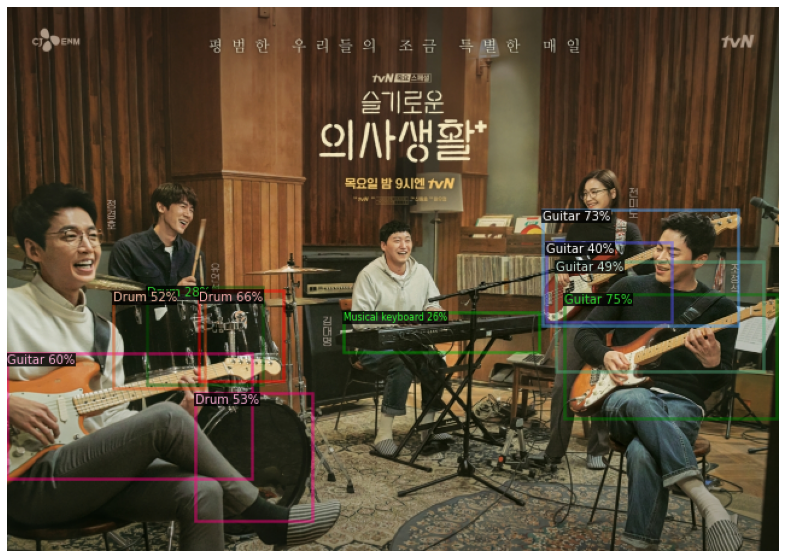

In [15]:
im = cv2.imread("../images/sample.jpg")
detect(im, predictor)